# Error budgeting for quantum error correction

*Want to follow along? {download}`Download this notebook.<error_budgeting.ipynb>`*

In this guide, you will learn what is error budgeting and how you can use `deltakit` to 
get an error budget. 

## What is error budgeting

Error budgeting has been introduced in 

> Google Quantum AI. Exponential suppression of bit or phase errors with cyclic error 
> correction. Nature 595, 383–387 (2021). https://doi.org/10.1038/s41586-021-03588-y

It aims at producing an error budget that can be visualised on a bar plot:

![example error budget](./example_error_budget.png)

The above graph represents a decomposition of $\Lambda^{-1}$ into different error
mechanisms.

Let us first understand what the above sentence means.

### The error scaling parameter $\Lambda$

$\Lambda$ is one of the most important parameter of quantum error-correction at the
moment. It is defined as the multiplicative factor by which the logical error
probability per round is modified each time the code distance is increased by $2$. In
other words:

$$
\epsilon_d = \frac{1}{\Lambda_0} \Lambda^{- \left\lfloor \frac{d+1}{2}\right\rfloor}
$$

where $\epsilon_d$ is the logical error probability per round at distance $d$ and
$\Lambda_0$ is a constant factor.

### $\Lambda^{-1}$ can be seen as a budget

Ideally, we would like $\Lambda$ to be as high as possible in order for the error
correction to be more efficient when increasing the code distance. Equivalently, we
would like $\Lambda^{-1}$ to go as close to $0$ as possible.

To start relating to the bar plot shown at the beginning of this notebook, we would like
each component of it to eventually go to $0$.

### Approximating $\Lambda^{-1}$

The whole goal of error-budgeting is to relate the value of $\Lambda^{-1}$ with the 
different noise strengths present when running your quantum error-correction experiment.

A core assumption of the error-budgeting procedure is that $\Lambda^{-1}$ is
approximately linear in each error parameter. If $\left\{ p_i \right\}_i$ are the values
of each of the noise parameters representing the noise model of your hardware, $\vec{p}$
is a vector containing each of them, then 

$$
\Lambda^{-1} \left(\vec{p}\right) \approx \sum_{i} \alpha_i p_i
$$

Based on the above approximation and the additional assumption that
$\lim_{\vec{p} \to \vec{0}} \Lambda^{-1} \left(\vec{p}\right) = 0$ (i.e., $\Lambda$ goes
to infinity when the noise tends to $0$), we can approximate $\Lambda^{-1}$ using a
Taylor expansion of the first order

$$
\Lambda^{-1} \left(\vec{p}\right) = \nabla \left[\Lambda^{-1}\right] \cdot \vec{p}
+ \mathcal{O}\left(\vec{p}\right)
$$

or of the second order

$$
\Lambda^{-1} \left(\vec{p}\right) = \nabla \left[\Lambda^{-1}\right] \cdot \vec{p}
+ \vec{p}^T H \vec{p}
+ \mathcal{O}\left(\vec{p}^2\right)
$$

where $H$ is the Hessian matrix, representing each second-order partial derivative of 
$\Lambda^{-1}$.


## Error budgeting on a simple noise model

### Implementing your noise model

In order to compute an error budget, you need to have access to a detailed and accurate
noise model. This noise model should be provided as a callable that takes a circuit and
a list of floating-point values as input and returns a new circuit with noise annotations.

Below is an example implementation for a simple noise model only containing one noise
parameter corresponding to the gate error.

In [1]:
from __future__ import annotations

import numpy as np
import numpy.typing as npt

from deltakit_circuit import Circuit, NoiseProfile
from deltakit_circuit.noise_channels import Depolarise1, Depolarise2
from deltakit_explorer.qpu import NoiseParameters, QPU

def simple_noise_model(circuit: Circuit, noise_parameters: npt.NDArray[np.floating]) -> Circuit:
    """A simple 1-parameter noise model.

    Args:
        circuit: quantum circuit to annotate with noise.
        noise_parameters: an array containing at least one entry. The first entry should
            represent the gate noise parameter. All other entries are ignored.

    Returns:
        a new quantum circuit representing ``circuit`` with depolarising noise
        annotations for 1- and 2-qubit gates.
    """
    gate_noise: list[NoiseProfile] = [
        lambda noise_context: Depolarise1.generator_from_prob(
            noise_parameters[0]
        )(noise_context.gate_layer_qubits(None, gate_qubit_count=1)),
        lambda noise_context: Depolarise2.generator_from_prob(
            noise_parameters[0]
        )(noise_context.gate_layer_qubits(None, gate_qubit_count=2))
    ]
    qpu = QPU(
        circuit.qubits, noise_model=NoiseParameters(gate_noise=gate_noise)
    )
    return qpu.compile_and_add_noise_to_circuit(circuit)

noise_parameter_names = ["Gate error"]

### Calibrating your noise parameters

Our goal is to have an error-budget that is representative of a real hardware, in order
to understand the effects of potential improvements to one of the error mechanism. That
means that you should have a good estimation of your noise parameter calibration.

Because this tutorial is not targeting a real hardware, we will define the "calibrated"
point arbitrarily.

In [2]:
P = [5e-3]

### Define how to compute $\Lambda^{-1}$

In order to compute an error budget, we need to be able to compute $\Lambda^{-1}$. 
$\Lambda^{-1}$ can be computed from $\Lambda$ by simply inversing. Computing $\Lambda$
requires to have access to the logical error probability per round for at least $2$ 
different distances. Computing the logical error probability per round for each distance
requires to have access to the logical error probability for at least one known number
of rounds.

That means that, in order to compute $\Lambda^{-1}$, we need:

- a set of distances $D = \left\{d_i\right\}_i$ such that $\vert D \vert \geqslant 2$,
- for each distance $d_i$, a number of rounds to estimate the logical error probability 
  with.

This is encoded as a dictionary in `deltakit`, where keys are the values of $d_i$ and
values are lists containing the number of rounds to use.

A few hints on which values should be used here:

- `sum(len(v)) for v in num_rounds_per_distance.values())` is the number of quantum
  circuits that need to be generated and simulated for each evaluation of $\Lambda^{-1}$,
  so it might be best to try to keep that value low.
- Estimations of $\Lambda$ may be unreliable when data from distance $3$ is used and the
  value of $\Lambda$ is low (see Fig. S15 of Supplementary information of "Quantum error
  correction below the surface code threshold" at 
  https://www.nature.com/articles/s41586-024-08449-y#Sec8). If such a case is encountered,
  a warning will be emitted and the estimation will continue.
- If only one number of rounds is provided (as in the code cell below), State Preparation
  And Measurement (SPAM) error will be assumed to be $0$ and a warning will be emitted
  to make the user aware of the assumption. If you expect SPAM error to be non-negligible
  (e.g., when the number of rounds is small, e.g., $\lessapprox 10$), either use multiple
  round numbers to use a fitting approach that is able to estimate SPAM error too or
  increase your number of rounds.

Most of the time, the following value is enough. It will depend on your expected logical
error probability per round though, so feel free to play around with the below value.

In [3]:
num_rounds_per_distance: dict[int, list[int]] = {d: [16] for d in [3, 5, 7]}
# Because we only used one number of rounds above ([16] and not something like [16, 32])
# a warning will be emitted at each computation of lambda saying that SPAM error is 
# assumed to be 0. Filtering out that warning to never appear.
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*one valid data-point provided for logical error probability per round.*",
    append=True
)

### Defining bounds on your noise parameters

In order for noise budgeting to be as accurate as possible, it is better to provide bounds
for each noise parameter. Bounds should be such that, when only changing the noise
parameter concerned (and not the other ones):

- for each distance considered, the logical error probability of a memory experiment with
  the lower bound should be such that we observe at least around ~10 logical errors
  (i.e., $ \text{num\_shots} \times \text{lep} \approx 10$).
- for each distance considered, the logical error probability of a memory experiment with
  the upper bound should be such that the logical error probability is slightly below 
  $0.5$. This is to reduce the odds of witnessing a number of fails that would lead to
  an estimation of the logical error probability that is above $0.5$, which is
  unsupported at the moment.

In general, the larger the interval defined by the bounds, the lower the standard deviation
of the error budget contributions.

For our simple noise model, the following bounds seems to experimentally verify the above
conditions. 

In [4]:
bounds: list[tuple[float, float]] = [(1e-3, 2e-2)]

### Call the error budgeting procedure

With all the required inputs defined above it is now trivial to call the error budgeting
function that will generate all the required quantum circuits and compute an error
budget.

In [5]:
from deltakit.explorer.analysis.error_budget import get_error_budget, SamplingParameters

results = get_error_budget(
    simple_noise_model, P, num_rounds_per_distance, bounds,
    sampling_parameters=SamplingParameters(max_shots=500_000)
)
contributions, contribution_stddevs = results.contributions, results.contribution_stddevs


Evaluating codes: 100%|██████████| 33/33 [01:13<00:00,  2.22s/it]
/Users/suau/Code/deltakit/deltakit-explorer/src/deltakit_explorer/analysis/_lambda.py:276: UserWarning: Lambda estimation is unreliable at low code distances and low values of lambda. Please use distance 5 as a minimum.
  warnings.warn(
/Users/suau/Code/deltakit/deltakit-explorer/src/deltakit_explorer/analysis/_lambda.py:276: UserWarning: Lambda estimation is unreliable at low code distances and low values of lambda. Please use distance 5 as a minimum.
  warnings.warn(
/Users/suau/Code/deltakit/deltakit-explorer/src/deltakit_explorer/analysis/_lambda.py:276: UserWarning: Lambda estimation is unreliable at low code distances and low values of lambda. Please use distance 5 as a minimum.
  warnings.warn(


### Plot the resulting error-budgeting

Once computed, it is easy to plot the result of error-budgeting by simply calling
`plot_error_budget`.

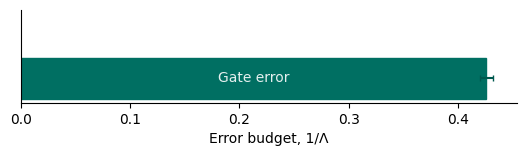

In [6]:
from deltakit.explorer.analysis.error_budget import plot_error_budget

fig, ax = plot_error_budget(
    contributions, noise_parameter_names, 3 * contribution_stddevs
)

## Error budgeting using different parameters

### Adding excess noise

The goal of error-budgeting is to be used to understand the major contributors to a
degraded error suppression on a real quantum hardware, to guide hardware improvement by
addressing the most important issues first.

If $\Lambda$ was computed on the hardware of interest, error-budgeting offers a nice way
of visualising the quality of the results: because the budget computed is supposed to be
equal to $\Lambda^{-1}$, we can compare the budget with the value of $\Lambda^{-1}$
computed on the hardware. 

The difference between the two quantities is often called "Excess error" and account for
both loose approximations in the error-budgeting process and either imprecisely
calibrated or simply missing error mechanisms.

Because this notebook is just an example, we will compare the error-budgeting estimation
with an estimation of $\Lambda^{-1}$ computed on the same noise model.

Evaluating codes: 100%|██████████| 3/3 [01:28<00:00, 29.35s/it]

Computed 1 / Λ = 0.41629 ± 0.00077702


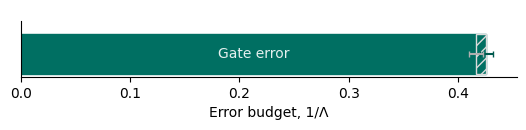

In [7]:
from deltakit_explorer.analysis.error_budget import inverse_lambda_at

lambda_reciprocal, lambda_reciprocal_stddev = inverse_lambda_at(
    simple_noise_model, P, num_rounds_per_distance
)
print(f"Computed 1 / Λ = {lambda_reciprocal:.5g} ± {lambda_reciprocal_stddev:.5g}")

contributions = [*contributions, lambda_reciprocal - sum(contributions)]
contribution_stddevs = [*(3 * contribution_stddevs), None]
descriptions = [*noise_parameter_names, "Excess"]

fig, ax = plot_error_budget(contributions, descriptions, contribution_stddevs)

In the above picture, we can see that the estimated $\Lambda^{-1}$ from the sensitivity of the 
"Gate error" noise parameter is slightly above the direct estimation of $\Lambda^{-1}$,
which is why the "Excess noise" appears to be negative.

### Computing the error budget with another QEC code

The default implementation of error-budgeting is assuming a pretty standard rotated
surface code implementation. Changing that default is pretty easy:

1. Implement the `MemoryGenerator` interface for the specific code and implementation you would like to have.
2. Provide that implementation to the `get_error_budget` call.

For example, performing error-budgeting with an unrotated surface code should be as easy
as:

Evaluating codes: 100%|██████████| 33/33 [04:57<00:00,  9.03s/it]
/Users/suau/Code/deltakit/deltakit-explorer/src/deltakit_explorer/analysis/_lambda.py:276: UserWarning: Lambda estimation is unreliable at low code distances and low values of lambda. Please use distance 5 as a minimum.
  warnings.warn(
/Users/suau/Code/deltakit/deltakit-explorer/src/deltakit_explorer/analysis/_lambda.py:276: UserWarning: Lambda estimation is unreliable at low code distances and low values of lambda. Please use distance 5 as a minimum.
  warnings.warn(
/Users/suau/Code/deltakit/deltakit-explorer/src/deltakit_explorer/analysis/_lambda.py:276: UserWarning: Lambda estimation is unreliable at low code distances and low values of lambda. Please use distance 5 as a minimum.
  warnings.warn(
Evaluating codes: 100%|██████████| 3/3 [02:44<00:00, 54.88s/it]

Computed 1 / Λ = 0.35134 ± 0.0005893


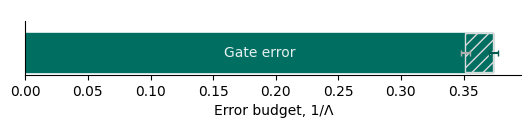

In [8]:
from deltakit_circuit.gates import PauliBasis

from deltakit_explorer.codes import css_code_memory_circuit, UnrotatedPlanarCode

def get_unrotated_surface_code_memory_circuit(distance: int, num_rounds: int) -> Circuit:
    """Returns a unrotated surface code Z memory experiment."""
    return css_code_memory_circuit(
        UnrotatedPlanarCode(distance, distance), num_rounds, PauliBasis.Z
    )

results = get_error_budget(
    simple_noise_model, P, num_rounds_per_distance, bounds, 
    memory_generator=get_unrotated_surface_code_memory_circuit,
    sampling_parameters=SamplingParameters(max_shots=1_000_000)
)
contributions, contribution_stddevs = results.contributions, results.contribution_stddevs

lambda_reciprocal, lambda_reciprocal_stddev = inverse_lambda_at(
    simple_noise_model, P, num_rounds_per_distance,
    memory_generator=get_unrotated_surface_code_memory_circuit
)
print(f"Computed 1 / Λ = {lambda_reciprocal:.5g} ± {lambda_reciprocal_stddev:.5g}")

contributions = [*contributions, lambda_reciprocal - sum(contributions)]
contribution_stddevs = [*(3 * contribution_stddevs), None]
descriptions = [*noise_parameter_names, "Excess"]

fig, ax = plot_error_budget(contributions, descriptions, contribution_stddevs)

### Using a more complex noise model

Using a different noise model is as simple as implementing a new function applying your
noise model to a circuit and using it as input to the `get_error_budgeting` function.
The new calibration should also be reflected (i.e., value of `P` in code above), and
ideally, new `bounds` should also be provided.

Evaluating codes: 100%|██████████| 3/3 [01:01<00:00, 20.37s/it]


Computed 1 / Λ = 0.33434 ± 0.0009235


Evaluating codes: 100%|██████████| 63/63 [03:08<00:00,  2.99s/it]
/Users/suau/Code/deltakit/deltakit-explorer/src/deltakit_explorer/analysis/_lambda.py:276: UserWarning: Lambda estimation is unreliable at low code distances and low values of lambda. Please use distance 5 as a minimum.
  warnings.warn(


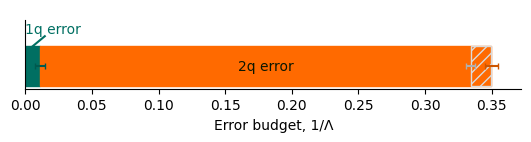

In [9]:
def simple2_noise_model(circuit: Circuit, noise_parameters: npt.NDArray[np.floating]) -> Circuit:
    """A simple 2-parameter noise model.

    Args:
        circuit: quantum circuit to annotate with noise.
        noise_parameters: an array containing at least 2 entries. The first entry should
            represent the 1-qubit gate noise parameter and the second should be for the
            2-qubit gate noise parameter. All other entries are ignored.

    Returns:
        a new quantum circuit representing ``circuit`` with depolarising noise
        annotations for 1- and 2-qubit gates.
    """
    gate_noise: list[NoiseProfile] = [
        lambda noise_context: Depolarise1.generator_from_prob(
            noise_parameters[0]
        )(noise_context.gate_layer_qubits(None, gate_qubit_count=1)),
        lambda noise_context: Depolarise2.generator_from_prob(
            noise_parameters[1]
        )(noise_context.gate_layer_qubits(None, gate_qubit_count=2))
    ]
    qpu = QPU(
        circuit.qubits, noise_model=NoiseParameters(gate_noise=gate_noise)
    )
    return qpu.compile_and_add_noise_to_circuit(circuit)

simple2_noise_parameter_names = ["1q error", "2q error"]


P = [2e-3, 4e-3]
bounds = [(2e-4, 5e-3), (5e-4, 1e-2)]

lambda_reciprocal, lambda_reciprocal_stddev = inverse_lambda_at(
    simple2_noise_model, P, num_rounds_per_distance
)
print(f"Computed 1 / Λ = {lambda_reciprocal:.5g} ± {lambda_reciprocal_stddev:.5g}")

results = get_error_budget(
    simple2_noise_model, P, num_rounds_per_distance, bounds,
    sampling_parameters=SamplingParameters(max_shots=2_000_000),
)
contributions, contribution_stddevs = results.contributions, results.contribution_stddevs

contributions = [*contributions, lambda_reciprocal - sum(contributions)]
contribution_stddevs = [*(3 * contribution_stddevs), None]
descriptions = [*simple2_noise_parameter_names, "Excess"]

fig, ax = plot_error_budget(contributions, descriptions, contribution_stddevs)